<font color = blue> **" Checkpoint 1: Data Cleaning 1"** </font>

In [1]:
# Importing libraries for the assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Creating pandas dataframe for rounds 
rounds2=pd.read_csv('rounds2.csv',encoding = 'ISO-8859-1')
rounds2.head(3)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0


In [3]:
# Creating pandas dataframe for companies 
companies = pd.read_csv("companies.txt",sep='\t', encoding = "ISO-8859-1")
companies.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN


In [4]:
# Number of unique companies are present in rounds2
rounds2['company_permalink']=rounds2['company_permalink'].str.upper()
rounds2.company_permalink.nunique()

66370

In [5]:
# Number of unique companies are present in companies
companies['permalink']=companies['permalink'].str.upper()
companies.permalink.nunique()

66368

In [6]:
# Are there any companies in the rounds2 file which are not present in companies?
result=(rounds2.company_permalink.nunique()==companies.permalink.nunique())
result
# Hence there are companies in rounds2 which are not present in companies

False

In [7]:
# Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. 
# Name the merged frame master_frame. How many observations are present in master_frame?
master_frame_df=pd.merge(companies,rounds2, left_on='permalink',right_on='company_permalink', how='outer')
master_frame=master_frame_df.drop_duplicates()
# Replace NaN in raised_amount_usd column with 0
master_frame.raised_amount_usd.fillna(0,inplace=True)
master_frame_observation=master_frame.permalink.count()
master_frame_observation

114947

<font color = blue> **" Checkpoint 2: Funding Type Analysis - Investment type analysis. "** </font>

In [8]:
# Average funding amount for venture type
avg_venture=master_frame.loc[master_frame['funding_round_type'] == 'venture','raised_amount_usd'].mean()
avg_venture

10634054.43608318

In [9]:
# Average funding amount for angel type
avg_angel=master_frame.loc[master_frame['funding_round_type'] == 'angel', 'raised_amount_usd'].mean()
avg_angel

764564.3457499179

In [10]:
# Average funding amount for seed type
avg_seed=master_frame.loc[master_frame['funding_round_type'] == 'seed','raised_amount_usd'].mean()
avg_seed

556606.7416131569

In [11]:
# Average funding amount for private equity type
avg_private_equity=master_frame.loc[master_frame['funding_round_type'] == 'private_equity','raised_amount_usd'].mean()
avg_private_equity

62111788.2297593

In [12]:
# Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round,which investment type is the most suitable for them?
funding_type=['private_equity','venture','seed','angel']
investment_type = [funding_type[i] for i in range (0,len(funding_type)) if 5000000<= (master_frame.loc[master_frame['funding_round_type'] == funding_type[i], 'raised_amount_usd'].mean())<= 15000000]
print(investment_type)

['venture']


<font color = blue> **"Checkpoint 3: Country Analysis"** </font>

In [13]:
# Filter table for 'venture' funding_round_type
venture_df=master_frame.loc[master_frame['funding_round_type']=='venture']
# Group the table by country values and calculate the sum 
country_df=venture_df.groupby('country_code').agg({'raised_amount_usd':sum})
# Data frame named top9 with the top nine countries (based on the total investment amount each country has received)
top_countries=country_df.sort_values(by='raised_amount_usd',ascending=False)
top9=top_countries.head(9).reset_index()
top9

,country_code,raised_amount_usd
0,USA,4.225108e+11
1,CHN,3.983542e+10
2,GBR,2.024563e+10
3,IND,1.439186e+10
4,CAN,9.583332e+09
5,FRA,7.259537e+09
6,ISR,6.907515e+09
7,DEU,6.346960e+09
8,JPN,3.363677e+09


<font color = blue> **"Checkpoint 4: Sector Analysis 1"** </font>

In [14]:
# Extract the primary sector of each category list from the category_list column
category=pd.Series.to_frame(master_frame['category_list'].str.split("|").str[0]).dropna()
# Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors
mapping=pd.read_csv("mapping.csv",encoding='ISO-8859-1')
mapping_df = mapping.drop(columns='Blanks').dropna()
# Generate dataframe with primary sector and main sector mapping
mapped_values=pd.merge(category,mapping_df,on='category_list',how='inner')
main_sector_df=mapped_values.rename(index=str, columns={"category_list": "primary_sector"})
sector_frame=pd.melt(main_sector_df, id_vars=['primary_sector'], value_vars=['Automotive & Sports','Cleantech / Semiconductors','Entertainment','Health','Manufacturing','News, Search and Messaging','Others','Social, Finance, Analytics, Advertising'])
sector_frame= sector_frame[(sector_frame[['value']] != 0).all(axis=1)].drop_duplicates()
sector_frame=sector_frame.drop(['value'], axis=1).rename(index=str,columns={"variable":"main_sector"}).dropna(how='any',axis=0) 
sector_frame.head(3)

,primary_sector,main_sector
53064,Sports,Automotive & Sports
57384,Design,Automotive & Sports
58548,Designers,Automotive & Sports


<font color = blue>**"Checkpoint 5: Sector Analysis 2"**</font>

In [15]:
# Creating dataframe with venture funding type between the funding amount of 5-15M USD
venture_funding_between_5_15 = master_frame[(master_frame['funding_round_type']=='venture') & (master_frame['raised_amount_usd']>= 5000000)& (master_frame['raised_amount_usd']<= 15000000)]
venture_funding_between_5_15.drop_duplicates()
venture_funding_between_5_15_sector_mapping=pd.merge(venture_funding_between_5_15,sector_frame,left_on='category_list',right_on='primary_sector',how='inner')

<font color = brown> Data frames D1, D2 and D3 for each of the three countries containing the observations of venture funding type falling within the 5-15 million USD range </font>

In [16]:
# Data frames D1, D2 and D3 for USA,GBR and IND containing the observations of venture funding type falling within the 5-15 million USD 
D1=venture_funding_between_5_15_sector_mapping[venture_funding_between_5_15_sector_mapping['country_code'] == 'USA']
D2=venture_funding_between_5_15_sector_mapping[venture_funding_between_5_15_sector_mapping['country_code'] == 'GBR']
D3=venture_funding_between_5_15_sector_mapping[venture_funding_between_5_15_sector_mapping['country_code'] == 'IND']

In [17]:
#Total number of investments (count) for USA
D1_investment_count=D1.raised_amount_usd.count()
D1_investment_count

5949

In [18]:
#Total number of investments (count) for GBR
D2_investment_count=D2.raised_amount_usd.count()
D2_investment_count

337

In [19]:
#Total number of investments (count) for IND
D3_investment_count=D3.raised_amount_usd.count()
D3_investment_count

173

In [20]:
#Total amount of investment (USD) for USA
D1_investment_sum=D1.raised_amount_usd.sum()
D1_investment_sum

53272315512.0

In [21]:
#Total amount of investment (USD) for GBR
D2_investment_sum=D2.raised_amount_usd.sum()
D2_investment_sum

2971451457.0

In [22]:
#Total amount of investment (USD) for IND
D3_investment_sum=D3.raised_amount_usd.sum()
D3_investment_sum

1517298277.0

<font color = brown>The total count and  total amount of investments  for each main sector in a separate columns</font>

In [23]:
# The total number (or count) of investments for each main sector for USA
D1_sector_count=pd.Series.to_frame(D1.groupby('main_sector').raised_amount_usd.count().sort_values(ascending=False))
D1_sector_sum=pd.Series.to_frame(D1.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False))
D1_sector=pd.merge(D1_sector_count,D1_sector_sum,on='main_sector').reset_index()
D1_main_sector=D1_sector.rename(index=str, columns={'raised_amount_usd_x':'count','raised_amount_usd_y':'sum'})
D1_main_sector.head(3)

,main_sector,count,sum
0,Others,2069,1.849231e+10
1,Cleantech / Semiconductors,1737,1.594099e+10
2,Health,601,5.405750e+09


In [24]:
# The total number (or count) of investments for each main sector for GBR
D2_sector_count=pd.Series.to_frame(D2.groupby('main_sector').raised_amount_usd.count().sort_values(ascending=False))
D2_sector_sum=pd.Series.to_frame(D2.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False))
D2_sector=pd.merge(D2_sector_count,D2_sector_sum,on='main_sector').reset_index()
D2_main_sector=D2_sector.rename(index=str, columns={'raised_amount_usd_x':'count','raised_amount_usd_y':'sum'})
D2_main_sector.head(3)

,main_sector,count,sum
0,Cleantech / Semiconductors,107,942829246.0
1,Others,106,931205523.0
2,"News, Search and Messaging",31,274140008.0


In [25]:
# The total number (or count) of investments for each main sector for IND
D3_sector_count=pd.Series.to_frame(D3.groupby('main_sector').raised_amount_usd.count().sort_values(ascending=False))
D3_sector_sum=pd.Series.to_frame(D3.groupby('main_sector').raised_amount_usd.sum().sort_values(ascending=False))
D3_sector=pd.merge(D3_sector_count,D3_sector_sum,on='main_sector').reset_index()
D3_main_sector=D3_sector.rename(index=str, columns={'raised_amount_usd_x':'count','raised_amount_usd_y':'sum'})
D3_main_sector.head(3)

,main_sector,count,sum
0,Others,74,675169507.0
1,"News, Search and Messaging",31,267118770.0
2,Entertainment,19,156150000.0


In [26]:
#Top sector (based on count of investments) for USA
top_sector_count_C1=D1_main_sector['main_sector'][0]
top_sector_count_C1

'Others'

In [27]:
#Top sector (based on count of investments) for GBR
top_sector_count_C2=D2_main_sector['main_sector'][0]
top_sector_count_C2

'Cleantech / Semiconductors'

In [28]:
#Top sector (based on count of investments) for IND
top_sector_count_C3=D3_main_sector['main_sector'][0]
top_sector_count_C3

'Others'

In [29]:
#Second-best sector (based on count of investments) for USA
second_best_sector_count_C1=D1_main_sector['main_sector'][1]
second_best_sector_count_C1

'Cleantech / Semiconductors'

In [30]:
#Second-best sector (based on count of investments) for GBR
second_best_sector_count_C2=D2_main_sector['main_sector'][1]
second_best_sector_count_C2

'Others'

In [31]:
#Second-best sector (based on count of investments) for IND
second_best_sector_count_C3=D3_main_sector['main_sector'][1]
second_best_sector_count_C3

'News, Search and Messaging'

In [32]:
#Third-best sector (based on count of investments) for USA
third_best_sector_count_C1=D1_main_sector['main_sector'][2]
third_best_sector_count_C1

'Health'

In [33]:
#Third-best sector (based on count of investments) for GBR
third_best_sector_count_C2=D2_main_sector['main_sector'][2]
third_best_sector_count_C2

'News, Search and Messaging'

In [34]:
#Third-best sector (based on count of investments) for IND
third_best_sector_count_C3=D3_main_sector['main_sector'][2]
third_best_sector_count_C3

'Entertainment'

In [35]:
#Number of investments in the top sector for USA
top_sector_investment_C1=D1_main_sector['count'][0]
top_sector_investment_C1

2069

In [36]:
#Number of investments in the top sector for GBR
top_sector_investment_C2=D2_main_sector['count'][0]
top_sector_investment_C2

107

In [37]:
#Number of investments in the top sector for IND
top_sector_investment_C3=D3_main_sector['count'][0]
top_sector_investment_C3

74

In [38]:
#Number of investments in the second-best sector for USA
second_best_sector_investment_C1=D1_main_sector['count'][1]
second_best_sector_investment_C1

1737

In [39]:
#Number of investments in the second-best sector for GBR
second_best_sector_investment_C2=D2_main_sector['count'][1]
second_best_sector_investment_C2

106

In [40]:
#Number of investments in the second-best sector for IND
second_best_sector_investment_C3=D3_main_sector['count'][1]
second_best_sector_investment_C3

31

In [41]:
#Number of investments in the third-best sector for USA
third_best_sector_investment_C1=D1_main_sector['count'][2]
third_best_sector_investment_C1

601

In [42]:
#Number of investments in the third-best sector for GBR
third_best_sector_investment_C2=D2_main_sector['count'][2]
third_best_sector_investment_C2

31

In [43]:
#Number of investments in the third-best sector for IND
third_best_sector_investment_C3=D3_main_sector['count'][3]
third_best_sector_investment_C3

14

In [44]:
#For the top sector count-wise (point 3), which company received the highest investment for USA?
top_sector_C1=D1.loc[D1['main_sector']==top_sector_count_C1]
company_name_top_sector_C1=(top_sector_C1.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_top_C1=(company_name_top_sector_C1.reset_index())['name'][0]
company_name_top_C1

'Virtustream'

In [45]:
#For the top sector count-wise (point 3), which company received the highest investment for GBR?
top_sector_C2=D2.loc[D2['main_sector']==top_sector_count_C2]
company_name_top_sector_C2=(top_sector_C2.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_top_C2=(company_name_top_sector_C2.reset_index())['name'][0]
company_name_top_C2

'EUSA Pharma'

In [46]:
#For the top sector count-wise (point 3), which company received the highest investment for IND?
top_sector_C3=D3.loc[D3['main_sector']==top_sector_count_C3]
company_name_top_sector_C3=(top_sector_C3.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_top_C3=(company_name_top_sector_C3.reset_index())['name'][0]
company_name_top_C3

'FirstCry.com'

In [47]:
#For the second-best sector count-wise (point 4), which company received the highest investment for USA?
second_best_sector_C1=D1.loc[D1['main_sector']==second_best_sector_count_C1]
company_name_second_sector_C1=(second_best_sector_C1.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_second_C1=(company_name_second_sector_C1.reset_index())['name'][0]
company_name_second_C1

'Tigo Energy'

In [48]:
#For the second-best sector count-wise (point 4), which company received the highest investment for GBR?
second_best_sector_C2=D2.loc[D2['main_sector']==second_best_sector_count_C2]
company_name_second_sector_C2=(second_best_sector_C2.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_second_C2=(company_name_second_sector_C2.reset_index())['name'][0]
company_name_second_C2

'Electric Cloud'

In [49]:
#For the second-best sector count-wise (point 4), which company received the highest investment for IND?
second_best_sector_C3=D3.loc[D3['main_sector']==second_best_sector_count_C3]
company_name_second_sector_C3=(second_best_sector_C3.groupby('name').agg({'raised_amount_usd': 'sum'})).sort_values(by='raised_amount_usd',ascending=False)
company_name_second_C3=(company_name_second_sector_C3.reset_index())['name'][0]
company_name_second_C3

'GupShup'

<font color = blue>**"Checkpoint 6: Plots"**</font>

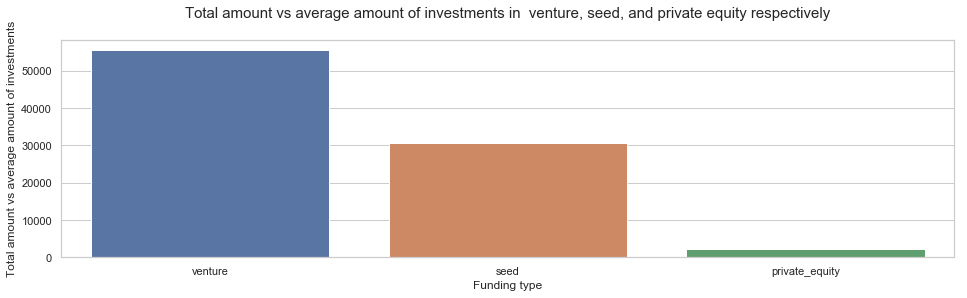

In [50]:
# Create plot for showing the fraction of total investments (globally) and the average amount of investment in  venture, seed, and private equity respectively
total_investment_frame=pd.Series.to_frame(master_frame.groupby('funding_round_type').agg('raised_amount_usd').sum()).sort_values(by='raised_amount_usd',ascending=False).reset_index()
total_investment_df=total_investment_frame.iloc[[0,6,1]]
average_investment_frame=pd.Series.to_frame(master_frame.groupby('funding_round_type').agg('raised_amount_usd').mean()).sort_values(by='raised_amount_usd',ascending=False).reset_index()
average_investment_df=average_investment_frame.iloc[[5,11,2]]
investment_df=pd.merge(total_investment_df,average_investment_df,on='funding_round_type',how='inner')
plt.figure(figsize=(16, 4))
sns.set(style="whitegrid")
sns.barplot(investment_df.funding_round_type,(investment_df.raised_amount_usd_x/investment_df.raised_amount_usd_y))
plt.title('Total amount vs average amount of investments in  venture, seed, and private equity respectively\n',fontsize=15)
plt.xlabel('Funding type', fontsize=12)
plt.ylabel('Total amount vs average amount of investments', fontsize=12)
plt.show()

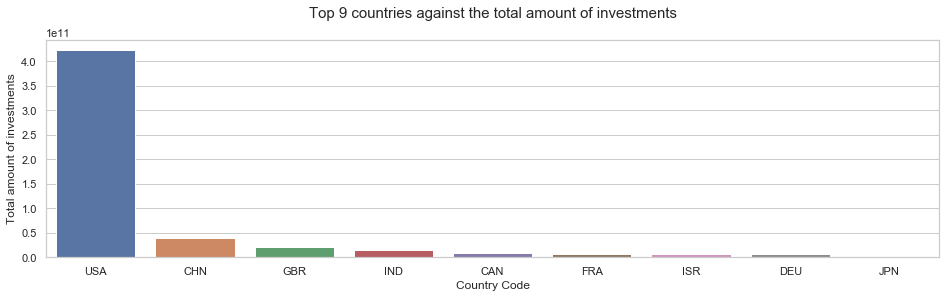

In [51]:
#The top 9 countries against the total amount of investments of venture funding type 
plt.figure(figsize=(16, 4))
sns.set(style="whitegrid")
sns.barplot(top9.country_code,top9.raised_amount_usd)
plt.title('Top 9 countries against the total amount of investments\n',fontsize=15)
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Total amount of investments', fontsize=12)
plt.show()

<Figure size 2160x720 with 0 Axes>

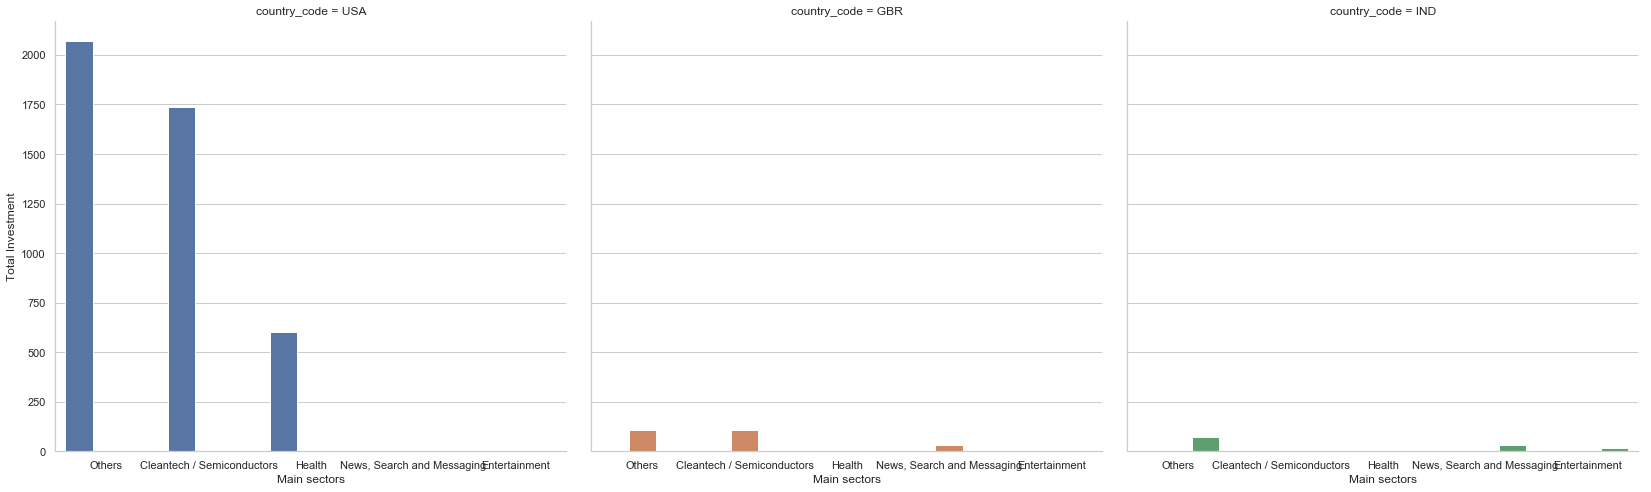

In [52]:
# A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart for the venture investment type 

# Function to filter country code, main sectors and the count of their investments
func={'country_code':(lambda x:x.mode()),'raised_amount_usd':'count'}

# New dataframes with country code, main sectors and the total amount 
USA_sector_df=D1[['country_code','main_sector','raised_amount_usd']]
GBR_sector_df=D2[['country_code','main_sector','raised_amount_usd']]
IND_sector_df=D3[['country_code','main_sector','raised_amount_usd']]

# Sort each country's dataframe and concat to form a single frame suitable to represent on the plot
USA_top_sector=USA_sector_df.groupby('main_sector').agg(func).sort_values(by='raised_amount_usd',ascending=False).reset_index()
GBR_top_sector=GBR_sector_df.groupby('main_sector').agg(func).sort_values(by='raised_amount_usd',ascending=False).reset_index()
IND_top_sector=IND_sector_df.groupby('main_sector').agg(func).sort_values(by='raised_amount_usd',ascending=False).reset_index()
USA_top_3_sector=USA_top_sector.iloc[[0,1,2]]
GBR_top_3_sector=GBR_top_sector.iloc[[0,1,2]]
IND_top_3_sector=IND_top_sector.iloc[[0,1,2]]
top_3_sector=[USA_top_3_sector,GBR_top_3_sector,IND_top_3_sector]
top_3_sector_countries=pd.concat(top_3_sector)

# Plot the chart to represent the top 3 sectors for each country
plt.figure(figsize=(30, 10))
sns.set(style="whitegrid")
#sns.catplot(x='main_sector', y='raised_amount_usd', hue='country_code', col='country_code',kind="bar",data=top_3_sector_countries)
g=sns.catplot(x="main_sector",y="raised_amount_usd",hue='country_code',col='country_code',data=top_3_sector_countries,kind="bar",height=7,aspect=1.1)
g.set_axis_labels("Main sectors","Total Investment").orient="h"